In [3]:
from IPython.display import display, Math, Latex, HTML

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import pdfkit

gum.config["notebook", "default_graph_size"] = 10

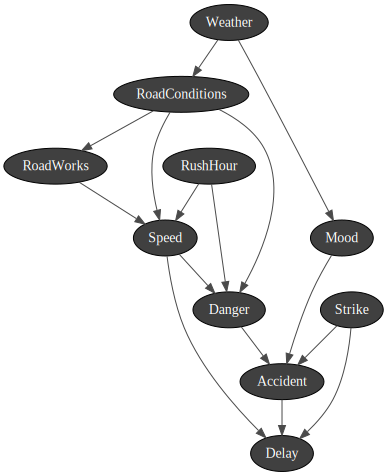

True

In [4]:
#construct network
m0 = gum.fastBN("Weather{Sun|Rain}->RoadConditions{Dry|Wet}->RoadWorks{False|True}->Speed{Slow"
                "|Fast};Weather->Mood{Good|Bad}->Accident{False|True}->Delay{False|True}<-Strike{False|True"
                "}->Accident<-Danger{Low|High}<-Speed<-RushHour{False|True}->Danger<-RoadConditions->Speed->Delay;")


gnb.showBN(m0, size=10)
graph = gnb.BN2dot(m0, size=100)
graph.write_pdf('network.pdf')

In [5]:
def common_data(list1, list2): 
    result = False
    # traverse in the 1st list 
    for x in list1: 
        # traverse in the 2nd list 
        for y in list2: 
            # if one common 
            if x == y: 
                result = True
                return result 


def getAncestors(cm,varSet):
    ancestors=varSet

    while len(varSet)>0:
        newparents=cm.parents(varSet[0])
        newparents = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, newparents) for i in b]
        newparents = [cm.names()[i] for i in newparents] 
        ancestors=ancestors+newparents
        varSet=varSet+newparents
        varSet.remove(varSet[0])
    return(ancestors)


def dSeparation(cm, varSet1, varSet2, evs):
    cmcopy=gum.fastBN("A")
    cmcopy.erase("A")
    [ cmcopy.add(name, 2) for name in cm.names()]
    for link in cm.arcs():
        cmcopy.addArc(*link)
    l1=cmcopy.names()
    l2=getAncestors(cmcopy,varSet1+varSet2+evs)
    #print(l2)
    l3 = [x for x in l1 if x not in l2]
    for i in l3:
        cmcopy.erase(i)
    m=cmcopy.moralGraph()
    if len(evs)>0:
        for i in evs:
            m.eraseNode(cmcopy.idFromName(i))
    #gnb.sideBySide(m)
    connComp=m.connectedComponents()
    #print(connComp)
    idVarSet1=[]
    idVarSet2=[]
    for i in varSet1:
        idVarSet1.append(cmcopy.idFromName(i))
    for i in varSet2:
        idVarSet2.append(cmcopy.idFromName(i))
    dSeparated=True
    for i in connComp:
        connCompSet=connComp[i]
        connCompSet= [i for b in map(lambda x:[x] if not isinstance(x, list) else x, connCompSet) for i in b]
        if common_data(connCompSet, idVarSet1) and common_data(connCompSet, idVarSet2):
            dSeparated=False
    del cmcopy
    return dSeparated


# D-separation


In [6]:
print(dSeparation(m0,["RushHour"], ["RoadConditions"], []))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Danger"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Speed"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Accident"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Delay"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["RoadWorks"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Strike"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Weather"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Mood"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Danger","Speed","Accident","Delay"]))

True
False
False
False
False
True
True
True
True
False


In [7]:
print(dSeparation(m0,["RushHour"], ["Strike"], []))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Danger"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Speed"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Accident"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Delay"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["RoadWorks"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["RoadConditions"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Weather"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Mood"]))

True
True
True
False
False
True
True
True
True


In [58]:
print(dSeparation(m0,["Speed"], ["Accident"], []))
print(dSeparation(m0,["Speed"], ["Accident"], ["Danger"]))
print(dSeparation(m0,["Speed"], ["Accident"], ["RushHour"]))
print(dSeparation(m0,["Speed"], ["Accident"], ["Strike"]))
print(dSeparation(m0,["Speed"], ["Accident"], ["Delay"]))
print(dSeparation(m0,["Speed"], ["Accident"], ["RoadWorks"]))
print(dSeparation(m0,["Speed"], ["Accident"], ["RoadConditions"]))
print(dSeparation(m0,["Speed"], ["Accident"], ["Weather"]))
print(dSeparation(m0,["Speed"], ["Accident"], ["Mood"]))

print(dSeparation(m0,["Speed"], ["Accident"], ["Danger", "RoadConditions"]))

False
False
False
False
False
False
False
False
False
True


In [59]:
print(dSeparation(m0,["RoadConditions"], ["Strike"], []))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["Danger"]))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["Speed"]))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["Accident"]))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["Delay"]))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["RushHour"]))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["RoadWorks"]))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["Weather"]))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["Mood"]))

True
True
True
False
False
True
True
True
True


In [10]:
print(dSeparation(m0,["Speed"], ["Mood"], []))
print(dSeparation(m0,["Speed"], ["Mood"], ["Danger"]))
print(dSeparation(m0,["Speed"], ["Mood"], ["RushHour"]))
print(dSeparation(m0,["Speed"], ["Mood"], ["Strike"]))
print(dSeparation(m0,["Speed"], ["Mood"], ["Delay"]))
print(dSeparation(m0,["Speed"], ["Mood"], ["RoadWorks"]))
print(dSeparation(m0,["Speed"], ["Mood"], ["RoadConditions"]))
print(dSeparation(m0,["Speed"], ["Mood"], ["Weather"]))
print(dSeparation(m0,["Speed"], ["Mood"], ["Accident"]))

False
False
False
False
False
False
True
True
False


# Conditional probability tables

In [11]:
m0.cpt("Weather")[:]=[0.70, 0.30]
m0.cpt("Strike")[:]=[0.96, 0.04]
m0.cpt("RushHour")[:]=[0.8, 0.2]

m0.cpt("RoadConditions")[{'Weather':'Sun'}]=[0.7, 0.3]
m0.cpt("RoadConditions")[{'Weather':'Rain'}]=[0.2, 0.8]

m0.cpt("Mood")[{'Weather':'Sun'}]= [0.7, 0.3]
m0.cpt("Mood")[{'Weather':'Rain'}]=[0.4, 0.6]

m0.cpt("RoadWorks")[{'RoadConditions':'Dry'}]=[0.3, 0.7]
m0.cpt("RoadWorks")[{'RoadConditions':'Wet'}]=[0.8, 0.2]

m0.cpt("Speed")[{'RoadConditions':'Dry', "RoadWorks":'True', 'RushHour':'True'}]=[0.85, 0.15]
m0.cpt("Speed")[{'RoadConditions':'Dry', "RoadWorks":'True', 'RushHour':'False'}]=[0.75, 0.25]
m0.cpt("Speed")[{'RoadConditions':'Dry', "RoadWorks":'False', 'RushHour':'True'}]=[0.8, 0.2]
m0.cpt("Speed")[{'RoadConditions':'Dry', "RoadWorks":'False', 'RushHour':'False'}]=[0.15, 0.85]
m0.cpt("Speed")[{'RoadConditions':'Wet', "RoadWorks":'True', 'RushHour':'True'}]=[0.95, 0.05]
m0.cpt("Speed")[{'RoadConditions':'Wet', "RoadWorks":'True', 'RushHour':'False'}]=[0.9, 0.1]
m0.cpt("Speed")[{'RoadConditions':'Wet', "RoadWorks":'False', 'RushHour':'True'}]=[0.8, 0.2]
m0.cpt("Speed")[{'RoadConditions':'Wet', "RoadWorks":'False', 'RushHour':'False'}]=[0.6, 0.4]

m0.cpt("Danger")[{'RoadConditions':'Dry', "Speed":'Slow', 'RushHour':'True'}]=[0.45, 0.55]
m0.cpt("Danger")[{'RoadConditions':'Dry', "Speed":'Slow', 'RushHour':'False'}]=[0.95, 0.05]
m0.cpt("Danger")[{'RoadConditions':'Dry', "Speed":'Fast', 'RushHour':'True'}]=[0.15, 0.85]
m0.cpt("Danger")[{'RoadConditions':'Dry', "Speed":'Fast', 'RushHour':'False'}]=[0.3, 0.7]
m0.cpt("Danger")[{'RoadConditions':'Wet', "Speed":'Slow', 'RushHour':'True'}]=[0.35, 0.65]
m0.cpt("Danger")[{'RoadConditions':'Wet', "Speed":'Slow', 'RushHour':'False'}]=[0.45, 0.55]
m0.cpt("Danger")[{'RoadConditions':'Wet', "Speed":'Fast', 'RushHour':'True'}]=[0.05, 0.95]
m0.cpt("Danger")[{'RoadConditions':'Wet', "Speed":'Fast', 'RushHour':'False'}]=[0.15, 0.85]

m0.cpt("Accident")[{'Strike':'True', "Mood":"Good",'Danger':'Low'}]=  [0.85, 0.15]
m0.cpt("Accident")[{'Strike':'True', "Mood":"Good",'Danger':'High'}]= [0.15, 0.85]
m0.cpt("Accident")[{'Strike':'True', "Mood":"Bad",'Danger':'Low'}]=   [0.30, 0.70]
m0.cpt("Accident")[{'Strike':'True', "Mood":"Bad",'Danger':'High'}]=  [0.05, 0.95]
m0.cpt("Accident")[{'Strike':'False',"Mood":"Good",'Danger':'Low'}]=  [0.95, 0.05]
m0.cpt("Accident")[{'Strike':'False',"Mood":"Good",'Danger':'High'}]= [0.40, 0.60]
m0.cpt("Accident")[{'Strike':'False',"Mood":"Bad",'Danger':'Low'}]=   [0.45, 0.55]
m0.cpt("Accident")[{'Strike':'False',"Mood":"Bad",'Danger':'High'}]=  [0.20, 0.80]

m0.cpt("Delay")[{"Speed":'Slow', 'Strike':'True', 'Accident':'True'}]=  [0.01, 0.99]
m0.cpt("Delay")[{"Speed":'Slow', 'Strike':'True', 'Accident':'False'}]= [0.35, 0.65]
m0.cpt("Delay")[{"Speed":'Slow', 'Strike':'False', 'Accident':'True'}]= [0.05, 0.95]
m0.cpt("Delay")[{"Speed":'Slow', 'Strike':'False', 'Accident':'False'}]=[0.75, 0.25]
m0.cpt("Delay")[{"Speed":'Fast', 'Strike':'True', 'Accident':'True'}]=  [0.01, 0.99]
m0.cpt("Delay")[{"Speed":'Fast', 'Strike':'True', 'Accident':'False'}]= [0.60, 0.40]
m0.cpt("Delay")[{"Speed":'Fast', 'Strike':'False', 'Accident':'True'}]= [0.05, 0.95]
m0.cpt("Delay")[{"Speed":'Fast', 'Strike':'False', 'Accident':'False'}]=[0.85, 0.15]

# to draw network and cpt
gnb.sideBySide(m0.cpt("Weather"), m0.cpt("Strike"), m0.cpt("RushHour"), m0.cpt("RoadConditions"),  m0.cpt('Mood'))

gnb.sideBySide(m0.cpt("RoadWorks"), m0.cpt('Speed'), m0.cpt('Danger'),  m0.cpt('Accident'),  m0.cpt('Delay'))

In [12]:
# Save cpts to file

# pdfkit.from_string(gnb.getPotential(m0.cpt("Weather"), digits=4),'weather.pdf')
# pdfkit.from_string(gnb.getPotential(m0.cpt("Strike"), digits=4),'strike.pdf')
# pdfkit.from_string(gnb.getPotential(m0.cpt("RushHour"), digits=4),'rushhour.pdf')
# pdfkit.from_string(gnb.getPotential(m0.cpt("RoadConditions"), digits=4),'roadconditions.pdf')
# pdfkit.from_string(gnb.getPotential(m0.cpt("Mood"), digits=4),'mood.pdf')
# pdfkit.from_string(gnb.getPotential(m0.cpt("RoadWorks"), digits=4),'roadworks.pdf')
# pdfkit.from_string(gnb.getPotential(m0.cpt("Speed"), digits=4),'speed.pdf')
# pdfkit.from_string(gnb.getPotential(m0.cpt("Danger"), digits=4),'danger.pdf')
# pdfkit.from_string(gnb.getPotential(m0.cpt("Accident"), digits=4),'accident.pdf')
# pdfkit.from_string(gnb.getPotential(m0.cpt("Delay"), digits=4),'delay.pdf')


# Causal Inference

## Calculate the causal effect of X on Y

In [13]:
cs0 = csl.CausalModel(m0)

cslnb.showCausalImpact(cs0, "Accident", doing="Speed", values={"Speed":"Slow"})
cslnb.showCausalImpact(cs0, "Accident", doing="Speed", values={"Speed":"Fast"})

## ACE

In [14]:
c1 = csl.causalImpact(cs0, "Accident",doing="Speed")[1]

# y-true
ACE = c1[0][1]-c1[1][1]
print(ACE)

-0.20094256


## C-specific effect

In [15]:
ie=gum.LazyPropagation(m0)
ie.addJointTarget({"RoadWorks","Speed","RoadConditions","Weather"})
ie.makeInference()
pYgivenXZC=ie.evidenceJointImpact(["Speed"],["RoadWorks", "RoadConditions", 'Weather'])
pZgivenC=ie.evidenceJointImpact(["RoadConditions"], ["Weather"])
gnb.sideBySide(pYgivenXZC,pZgivenC,
              captions=["$\\forall Danger,Delay,RoadConditions,Speed P(Delay|Danger,RoadConditions,Speed)$",
                        "$\\forall Speed,RoadConditions P(Speed|RoadConditions)$"]
                        )

result=pYgivenXZC.extract({"RoadConditions":0})*pZgivenC.extract({"RoadConditions":0})
result=result + pYgivenXZC.extract({"RoadConditions":1})*pZgivenC.extract({"RoadConditions":1})
gnb.sideBySide(result.putFirst("Speed"),
              captions=["$\\forall Delay,Danger,RoadConditions P(Delay|do(Danger),RoadConditions)$"])

## Conditional intervention

In [64]:
def g(c):
    x = 1 - c
    return x

# 	P(Y=0|do(X=g(C))) = \sum_c P(Y=0|do(X=g(C)), C=c)P(C=c) = 0.7388
e_0 = 0
for c in [0,1]:
    firstprob = result.extract({"RoadWorks":g(c), "Speed":0})
    print(m0.cpt("Weather")[c])
    e_0 = e_0 + firstprob[c] * m0.cpt("Weather")[c]
e_0

# 	P(Y=0|do(X=g(C))) = \sum_c P(Y=0|do(X=g(C)), C=c)P(C=c) = 0.2612

0.7
0.3


0.7387999999999998

## Mediation & Controlled Direct Effect

In [33]:
cslnb.showCausalImpact(cs0,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'False'})

In [34]:
# Danger: High
ci_R_T=csl.causalImpact(cs0,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'False', "RoadConditions":'Dry'})[1][1]
ci_R_F=csl.causalImpact(cs0,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'False', "RoadConditions":'Wet'})[1][1]

CDE= ci_R_T-ci_R_F
print('CDE =', str(ci_R_T), '-', str(ci_R_F), '=', str(CDE))

CDE = 0.7200000000000001 - 0.3600000000000001 = 0.36


In [35]:
# Danger: High
ci_R_T=csl.causalImpact(cs0,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'True', "RoadConditions":'Dry'})[1][1]
ci_R_F=csl.causalImpact(cs0,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'True', "RoadConditions":'Wet'})[1][1]

CDE= ci_R_T-ci_R_F
print('CDE =', str(ci_R_T), '-', str(ci_R_F), '=', str(CDE))

CDE = 0.23 - 0.09000000000000002 = 0.13999999999999999


In [36]:
# Danger: Low
ci_R_T=csl.causalImpact(cs0,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'False', "RoadConditions":'Dry'})[1][0]
ci_R_F=csl.causalImpact(cs0,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'False', "RoadConditions":'Wet'})[1][0]

CDE= ci_R_T-ci_R_F
print('CDE =', str(ci_R_T), '-', str(ci_R_F), '=', str(CDE))

CDE = 0.28 - 0.64 = -0.36


In [37]:
# Danger: Loe
ci_R_T=csl.causalImpact(cs0,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'True', "RoadConditions":'Dry'})[1][0]
ci_R_F=csl.causalImpact(cs0,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'True', "RoadConditions":'Wet'})[1][0]

CDE= ci_R_T-ci_R_F
print('CDE =', str(ci_R_T), '-', str(ci_R_F), '=', str(CDE))

CDE = 0.7700000000000001 - 0.9100000000000001 = -0.14


# Simulation

## Calculate the causal effect of X on Y

In [23]:
m1 = gum.fastBN("Weather{Sun|Rain}->RoadConditions{Dry|Wet}->RoadWorks{False|True}->Speed{Slow"
                "|Fast};Weather->Mood{Good|Bad}->Accident{False|True}->Delay{False|True}<-Strike{False|True"
                "}->Accident<-Danger{Low|High}<-Speed;Danger<-RoadConditions->Speed->Delay;")

cs1 = csl.CausalModel(m1, [("RushHour", ["Speed","Danger"])], True)

cslnb.showCausalImpact(cs1, "Accident", doing="Speed", values={"Speed":"Slow"})
cslnb.showCausalImpact(cs1, "Accident", doing="Speed", values={"Speed":"Fast"})

## ACE
Not computable

## C-specific effect
Not computable

## Conditional intervention
Not computable

## Mediation

In [45]:
m1 = gum.fastBN("RoadConditions{Dry|Wet}->RoadWorks{False|True}->Speed{Slow|Fast};Mood{Good|Bad}->Accident{False|True}->Delay{False|True}<-Strike{False|True"
                "}->Accident<-Danger{Low|High}<-Speed<-RushHour{False|True}->Danger<-RoadConditions->Speed->Delay;")

# m0.cpt("Weather")[:]=[0.70, 0.30]
m1.cpt("Strike")[:]=[0.96, 0.04]
m1.cpt("RushHour")[:]=[0.8, 0.2]

rc1 = 0.7 * 0.7 + 0.3 * 0.2
m1.cpt("RoadConditions")[:]=[rc1, 1-rc1]

mood1 = 0.7 * 0.7 + 0.3 * 0.4
m1.cpt("Mood")[:]= [mood1, 1-mood1]

m1.cpt("RoadWorks")[{'RoadConditions':'Dry'}]=[0.3, 0.7]
m1.cpt("RoadWorks")[{'RoadConditions':'Wet'}]=[0.8, 0.2]

m1.cpt("Speed")[{'RoadConditions':'Dry', "RoadWorks":'True', 'RushHour':'True'}]=[0.85, 0.15]
m1.cpt("Speed")[{'RoadConditions':'Dry', "RoadWorks":'True', 'RushHour':'False'}]=[0.75, 0.25]
m1.cpt("Speed")[{'RoadConditions':'Dry', "RoadWorks":'False', 'RushHour':'True'}]=[0.8, 0.2]
m1.cpt("Speed")[{'RoadConditions':'Dry', "RoadWorks":'False', 'RushHour':'False'}]=[0.15, 0.85]
m1.cpt("Speed")[{'RoadConditions':'Wet', "RoadWorks":'True', 'RushHour':'True'}]=[0.95, 0.05]
m1.cpt("Speed")[{'RoadConditions':'Wet', "RoadWorks":'True', 'RushHour':'False'}]=[0.9, 0.1]
m1.cpt("Speed")[{'RoadConditions':'Wet', "RoadWorks":'False', 'RushHour':'True'}]=[0.8, 0.2]
m1.cpt("Speed")[{'RoadConditions':'Wet', "RoadWorks":'False', 'RushHour':'False'}]=[0.6, 0.4]

m1.cpt("Danger")[{'RoadConditions':'Dry', "Speed":'Slow', 'RushHour':'True'}]=[0.45, 0.55]
m1.cpt("Danger")[{'RoadConditions':'Dry', "Speed":'Slow', 'RushHour':'False'}]=[0.95, 0.05]
m1.cpt("Danger")[{'RoadConditions':'Dry', "Speed":'Fast', 'RushHour':'True'}]=[0.15, 0.85]
m1.cpt("Danger")[{'RoadConditions':'Dry', "Speed":'Fast', 'RushHour':'False'}]=[0.3, 0.7]
m1.cpt("Danger")[{'RoadConditions':'Wet', "Speed":'Slow', 'RushHour':'True'}]=[0.35, 0.65]
m1.cpt("Danger")[{'RoadConditions':'Wet', "Speed":'Slow', 'RushHour':'False'}]=[0.45, 0.55]
m1.cpt("Danger")[{'RoadConditions':'Wet', "Speed":'Fast', 'RushHour':'True'}]=[0.05, 0.95]
m1.cpt("Danger")[{'RoadConditions':'Wet', "Speed":'Fast', 'RushHour':'False'}]=[0.15, 0.85]

m1.cpt("Accident")[{'Strike':'True', "Mood":"Good",'Danger':'Low'}]=  [0.85, 0.15]
m1.cpt("Accident")[{'Strike':'True', "Mood":"Good",'Danger':'High'}]= [0.15, 0.85]
m1.cpt("Accident")[{'Strike':'True', "Mood":"Bad",'Danger':'Low'}]=   [0.30, 0.70]
m1.cpt("Accident")[{'Strike':'True', "Mood":"Bad",'Danger':'High'}]=  [0.05, 0.95]
m1.cpt("Accident")[{'Strike':'False',"Mood":"Good",'Danger':'Low'}]=  [0.95, 0.05]
m1.cpt("Accident")[{'Strike':'False',"Mood":"Good",'Danger':'High'}]= [0.40, 0.60]
m1.cpt("Accident")[{'Strike':'False',"Mood":"Bad",'Danger':'Low'}]=   [0.45, 0.55]
m1.cpt("Accident")[{'Strike':'False',"Mood":"Bad",'Danger':'High'}]=  [0.20, 0.80]

m1.cpt("Delay")[{"Speed":'Slow', 'Strike':'True', 'Accident':'True'}]=  [0.01, 0.99]
m1.cpt("Delay")[{"Speed":'Slow', 'Strike':'True', 'Accident':'False'}]= [0.35, 0.65]
m1.cpt("Delay")[{"Speed":'Slow', 'Strike':'False', 'Accident':'True'}]= [0.05, 0.95]
m1.cpt("Delay")[{"Speed":'Slow', 'Strike':'False', 'Accident':'False'}]=[0.75, 0.25]
m1.cpt("Delay")[{"Speed":'Fast', 'Strike':'True', 'Accident':'True'}]=  [0.01, 0.99]
m1.cpt("Delay")[{"Speed":'Fast', 'Strike':'True', 'Accident':'False'}]= [0.60, 0.40]
m1.cpt("Delay")[{"Speed":'Fast', 'Strike':'False', 'Accident':'True'}]= [0.05, 0.95]
m1.cpt("Delay")[{"Speed":'Fast', 'Strike':'False', 'Accident':'False'}]=[0.85, 0.15]

cs1 = csl.CausalModel(m1, [("Weather", ["RoadConditions","Mood"])], True)

## Controlled Direct Effect

In [52]:
cslnb.showCausalImpact(cs1,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'False'})

In [53]:
# Danger: High
ci_R_T=csl.causalImpact(cs1,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'False', "RoadConditions":'Dry'})[1][1]
ci_R_F=csl.causalImpact(cs1,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'False', "RoadConditions":'Wet'})[1][1]

CDE= ci_R_T-ci_R_F
print('CDE =', str(ci_R_T), '-', str(ci_R_F), '=', str(CDE))

CDE = 0.7200000000000001 - 0.3600000000000001 = 0.36


In [54]:
# Danger: High
ci_R_T=csl.causalImpact(cs1,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'True', "RoadConditions":'Dry'})[1][1]
ci_R_F=csl.causalImpact(cs1,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'True', "RoadConditions":'Wet'})[1][1]

CDE= ci_R_T-ci_R_F
print('CDE =', str(ci_R_T), '-', str(ci_R_F), '=', str(CDE))

CDE = 0.23 - 0.09000000000000002 = 0.13999999999999999


In [55]:
# Danger: Low
ci_R_T=csl.causalImpact(cs1,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'False', "RoadConditions":'Dry'})[1][0]
ci_R_F=csl.causalImpact(cs1,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'False', "RoadConditions":'Wet'})[1][0]

CDE= ci_R_T-ci_R_F
print('CDE =', str(ci_R_T), '-', str(ci_R_F), '=', str(CDE))

CDE = 0.28 - 0.64 = -0.36


In [56]:
# Danger: Low
ci_R_T=csl.causalImpact(cs1,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'True', "RoadConditions":'Dry'})[1][0]
ci_R_F=csl.causalImpact(cs1,on={"Speed"}, doing={"RoadWorks","RoadConditions"}, values={"RoadWorks":'True', "RoadConditions":'Wet'})[1][0]

CDE= ci_R_T-ci_R_F
print('CDE =', str(ci_R_T), '-', str(ci_R_F), '=', str(CDE))

CDE = 0.7700000000000001 - 0.9100000000000001 = -0.14
